In [64]:
import plyfile
import numpy as np
import matplotlib.pyplot as plt

### Load data ###

In [65]:
# uniform sampling
def load_cow(every_ith=200):
    from plyfile import PlyData
    plydata = PlyData.read('cow.2D.ply')

    X = np.array([plydata["vertex"][c] for c in ["y", "x"]]).T
    X[:,1] = -X[:,1]
    N = np.array([plydata["vertex"][c] for c in ["ny", "nx"]]).T
    N[:,1] = -N[:,1]
    return X[::every_ith],N[::every_ith]

# Non uniform sampling, can play with weights
def load_cow_non_uniform(non_uniform_fraction=0.01):
    from plyfile import PlyData
    plydata = PlyData.read('cow.2D.ply')

    X = np.array([plydata["vertex"][c] for c in ["y", "x"]]).T
    X[:,1] = -X[:,1]
    N = np.array([plydata["vertex"][c] for c in ["ny", "nx"]]).T
    N[:,1] = -N[:,1]
    
    # Compute weights (e.g., based on distance from origin)
    weights = 1 / np.linalg.norm(X, axis=1)**2
    weights /= weights.sum()  # Normalize weights
    
    # Non-uniform sampling
    num_samples = int(non_uniform_fraction * X.shape[0])
    sampled_indices = np.random.choice(X.shape[0], size=num_samples, replace=False, p=weights)  # Weighted random sampling
    return X[sampled_indices], N[sampled_indices]

In [66]:
# Choose sampling method
data = load_cow()
# data = load_cow_non_uniform(non_uniform_fraction=0.005)

(500, 2)
(500, 2)


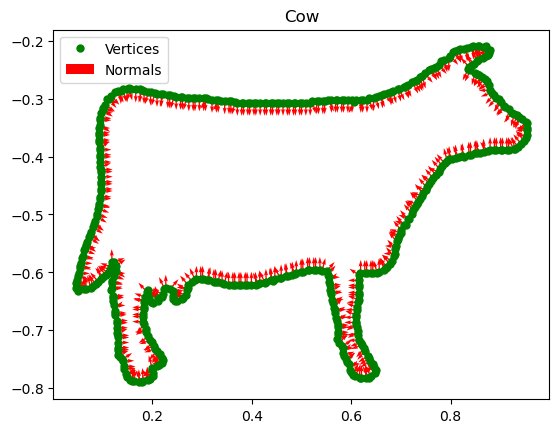

In [67]:
# Visualize data
print(data[0].shape)
print(data[1].shape)
X, N = data[0], data[1]
plt.plot(X[:,0], X[:,1], 'o', color='g',label="Vertices", markersize=5)
plt.quiver(X[:, 0], X[:, 1], N[:, 0], N[:, 1], angles='xy', scale_units='xy', color='r', label="Normals")
plt.legend()
plt.title("Cow")
plt.show()


### Define Triangulation ###

In [68]:
def compute_bounding_box(X):
    min_x = np.min(X[:,0])
    max_x = np.max(X[:,0])
    min_y = np.min(X[:,1])
    max_y = np.max(X[:,1])
    return min_x, max_x, min_y, max_y

def compute_grid(X, min_x, max_x, min_y, max_y, cell_size=0.1, padding=0.2):
    x = np.linspace(min_x - padding, max_x + padding, int((max_x - min_x) / cell_size))
    y = np.linspace(min_y - padding, max_y + padding, int((max_y - min_y) / cell_size))
    X, Y = np.meshgrid(x, y)
    return X, Y

In [69]:
# define grid domain
bounding_box = compute_bounding_box(X)
regular_grid = compute_grid(X, *bounding_box, cell_size=0.04, padding=0.2)

points = np.array([regular_grid[0].ravel(), regular_grid[1].ravel()]).T
print(points.shape)
print(points[0])

(308, 2)
[-0.153478   -0.99009801]


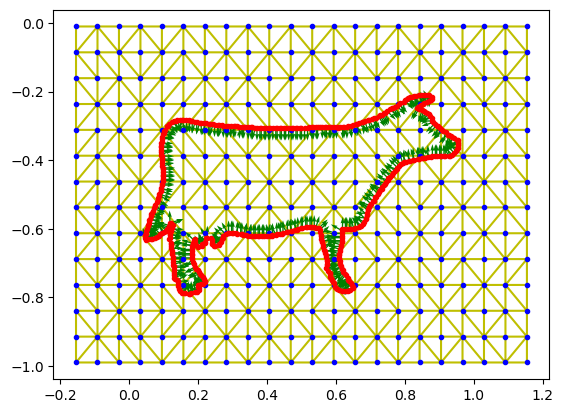

In [70]:
# compute Delaunay triangulation
from scipy.spatial import Delaunay
triangulation = Delaunay(points)
plt.triplot(points[:,0], points[:,1], triangulation.simplices, color='y')
plt.plot(points[:,0], points[:,1], 'o', color='b', markersize=3)
plt.plot(X[:,0], X[:,1], 'o', color='r', markersize=3)
plt.quiver(X[:, 0], X[:, 1], N[:, 0], N[:, 1], angles='xy', scale_units='xy', color='g', label="Normals")
plt.show()

### Compute $V$ ###

In [71]:
def compute_gradient_per_vertex(points, X, N, sigma=1.0):
    V = np.zeros((len(points), 2))
    for i in range(len(points)):
        for j in range(len(X)):
            weight = (np.exp(-np.linalg.norm(points[i] - X[j])**2 / (2 * np.pi * sigma**2)))
            V[i] += weight * N[j]
    return V

def compute_gradient_per_face(triangulation, V):
    F = np.zeros((len(triangulation.simplices), 2))
    for i, t in enumerate(triangulation.simplices):
        # Get the indices of the vertices of the triangle
        v0, v1, v2 = t

        # Get the vertex gradients
        grad0 = V[v0]
        grad1 = V[v1]
        grad2 = V[v2]

        # Compute the barycentric interpolation (uniform averaging)
        face_gradient = (grad0 + grad1 + grad2) / 3.0

        # Store the face gradient
        F[i] = face_gradient
    return F

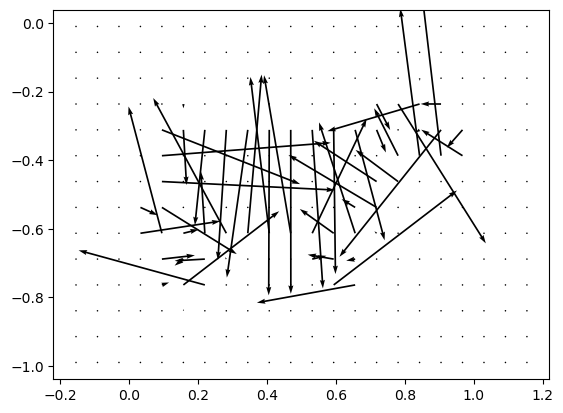

In [72]:
# visualize V for each vertex
V_vertex = compute_gradient_per_vertex(points, X, N, sigma=0.01)
plt.quiver(points[:,0], points[:,1], V_vertex[:,0], V_vertex[:,1])
plt.show()

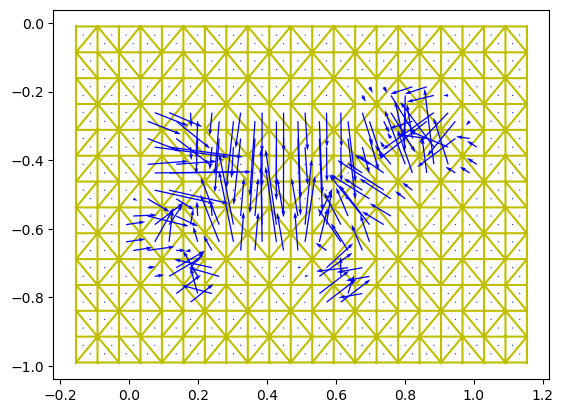

In [73]:
# visualize V for each face
V_face = compute_gradient_per_face(triangulation, V_vertex)
plt.triplot(points[:,0], points[:,1], triangulation.simplices, color='y')
centroids = np.mean(points[triangulation.simplices], axis=1)
plt.quiver(centroids[:,0], centroids[:,1], V_face[:,0], V_face[:,1], color='blue', scale_units='xy')
plt.show()


### Solve Poisson Equation ###

In [74]:
from gpytoolbox import grad, cotangent_laplacian, massmatrix
import scipy.sparse as sp

In [75]:
# Compute the face-wise mass matrix for a 2D triangle mesh.
def compute_face_mass_matrix(points, simplices):
    # Extract vertex positions for each triangle
    v0, v1, v2 = points[simplices[:, 0]], points[simplices[:, 1]], points[simplices[:, 2]]

    # Compute the area of each triangle using the determinant formula
    cross_product = (
        (v1[:, 0] - v0[:, 0]) * (v2[:, 1] - v0[:, 1]) -
        (v1[:, 1] - v0[:, 1]) * (v2[:, 0] - v0[:, 0])
    )
    areas = 0.5 * np.abs(cross_product)

    # Construct the diagonal matrix with areas
    face_mass_matrix = sp.diags(areas, format="csc")  # Sparse diagonal matrix

    return face_mass_matrix


In [76]:
G = grad(points, triangulation.simplices) # compute discrete gradient assuming piecewise linear hat function basis
L = cotangent_laplacian(points, triangulation.simplices)
M_face = compute_face_mass_matrix(points, triangulation.simplices) # NOTE: gpytoolbox.massmatrix(V, F) returns a vertex-wise mass matrix
M_g = sp.block_diag([M_face, M_face]) # "stretch" mass matrix from (m, m) to (2m, 2m) for x and y components in G matrix

# compute divergence of V 
D = G.T @ M_g @ V_face.T.flatten()

# solve the Poisson equation Ac = b <-> Lc = D
from scipy.sparse import linalg
A = L
b = D
c = linalg.spsolve(A, b)

In [77]:
# check if L is correct by computing divergence of gradient, L = G^T M G
L_debug = G.T @ M_g @ G
assert np.allclose(L.toarray(), L_debug.toarray()), "Laplacian matrix is not correct" # check if L is correct

# Print shapes
print(f'vertices: {points.shape}') #n, 2
print(f'simplices: {triangulation.simplices.shape}') #m, 3
print(f'L: {L.shape}') #n, #n
print(f'G: {G.shape}') #2*m, #n
print(f'M_face: {M_face.shape}') #m, #m
print(f'M_g: {M_g.shape}') #2*m, 2*m
print(f'V_face: {V_face.shape}') #m, 2

vertices: (308, 2)
simplices: (546, 3)
L: (308, 308)
G: (1092, 308)
M_face: (546, 546)
M_g: (1092, 1092)
V_face: (546, 2)


### Visualize solution ###

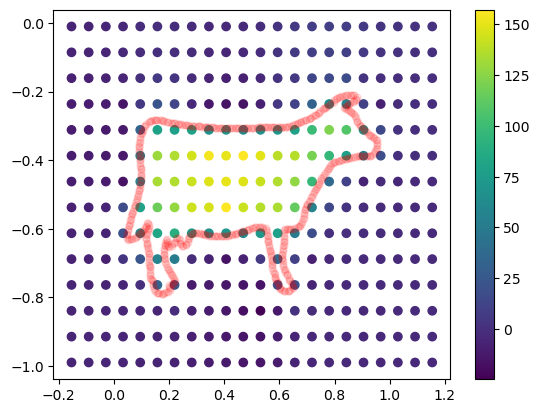

In [78]:
# visualize the solution for every vertex
plt.scatter(points[:, 0], points[:, 1], cmap='viridis', c=c) # with piecewise linear hat function basis, implicit function value at each vertex is just the corresponding coefficient
plt.plot(X[:,0], X[:,1], 'o', color='r', alpha=0.1, markersize=5)
plt.colorbar()
plt.show()

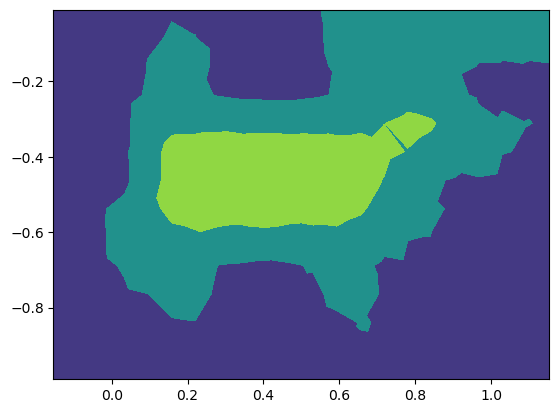

In [79]:
# Visualize the solution for each face
plt.tricontourf(points[:, 0], points[:, 1], triangulation.simplices, c,levels=1, cmap='viridis')
plt.colorbar
plt.show()